1. Install Dependencies and Setup

In [25]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
import datetime
import random
random.seed(42)

2. Remove dodgy images

In [26]:
data_dir = 'Data/2_classes_Brain_tumor' 

In [27]:
# image_exts = ['jpeg','jpg', 'bmp', 'png']

In [28]:
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             # os.remove(image_path)

3. Load Data

In [29]:
data = tf.keras.utils.image_dataset_from_directory('Data/2_classes_Brain_tumor')

Found 2999 files belonging to 2 classes.


In [30]:
print(len(data))

94


In [31]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000025562F00B10>)

In [32]:
batch = data_iterator.next()
batch

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.0000

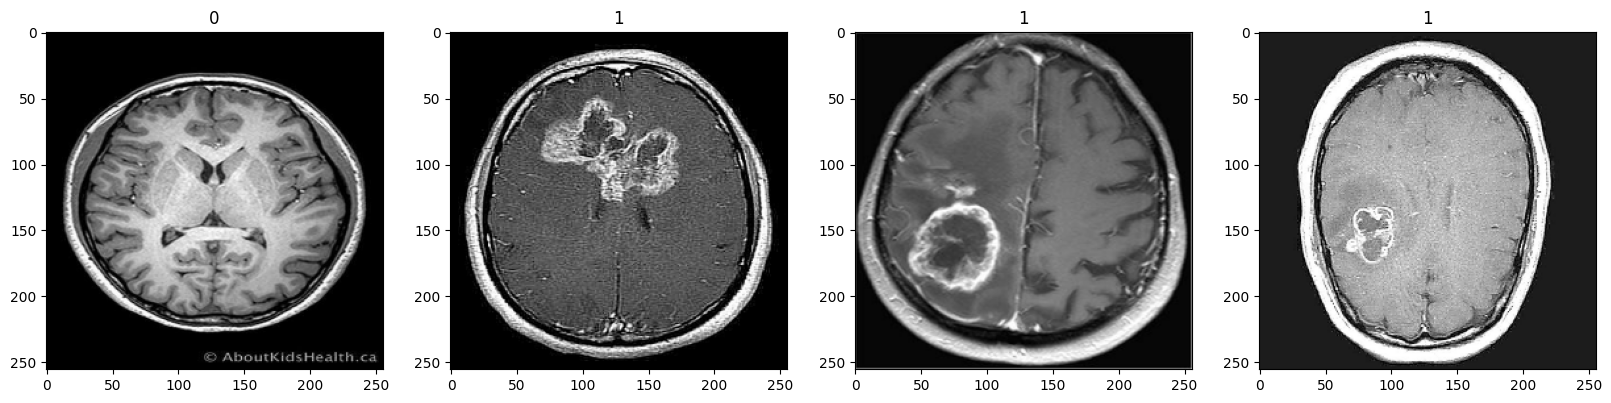

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Scale Data

In [34]:
data = data.map(lambda x,y: (x/255, y))

In [35]:
ds=data.as_numpy_iterator().next()

5. Split Data

In [36]:
dataset = []
labels = []

INPUT_SIZE = (256,256)

label_mapping = {
    'no': 0, 
    'yes': 1
}

for image_class in os.listdir(data_dir): 
    class_index = label_mapping[image_class]
    class_path = os.path.join(data_dir, image_class)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        if image_path.split('.')[-1] == 'jpg':
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, INPUT_SIZE)
            dataset.append(img)  
            labels.append(class_index)

dataset = np.array(dataset)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [37]:
# Reshape = (n, image_width, image_height, n_channel)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(2399, 256, 256, 3)
(2399,)
(600, 256, 256, 3)
(600,)


In [38]:
print(y_train)

[1 0 0 ... 1 1 1]


In [39]:
print(y_test)

[0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1
 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1
 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1
 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1
 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0
 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0
 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0
 1 1 1 0 1 0 1 1 0 1 1 0 

6. Build Deep Learning Model

In [40]:
model = Sequential()

In [41]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

7. Train

In [44]:
from keras.utils import to_categorical
from sklearn.preprocessing import normalize

In [45]:
logdir='logs'

In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:

tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)


# Sau đó sử dụng callback trong quá trình fit
hist = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.6775 - loss: 21.8023 - val_accuracy: 0.8400 - val_loss: 0.3843
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.8850 - loss: 0.2797 - val_accuracy: 0.9150 - val_loss: 0.2293
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.9757 - loss: 0.0906 - val_accuracy: 0.9333 - val_loss: 0.2285
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.9923 - loss: 0.0293 - val_accuracy: 0.9200 - val_loss: 0.2885
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9957 - loss: 0.0155 - val_accuracy: 0.9300 - val_loss: 0.3157
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.9975 - loss: 0.0161 - val_accuracy: 0.9317 - val_loss: 0.3236
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.9938 - loss: 0.0223 - val_accuracy: 0.9417 - val_loss: 0.2950
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.9973 - loss: 0.0073 - val_acc

8. Plot Performance

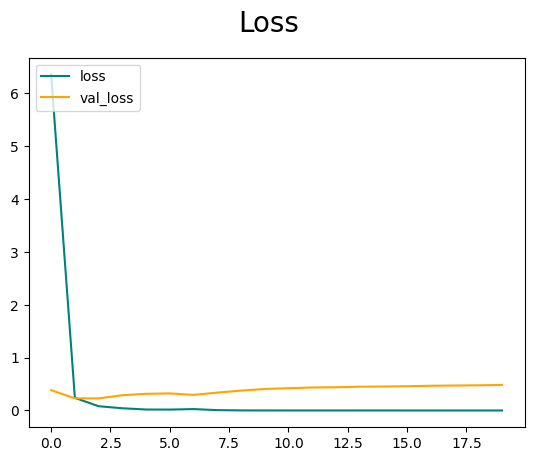

In [48]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

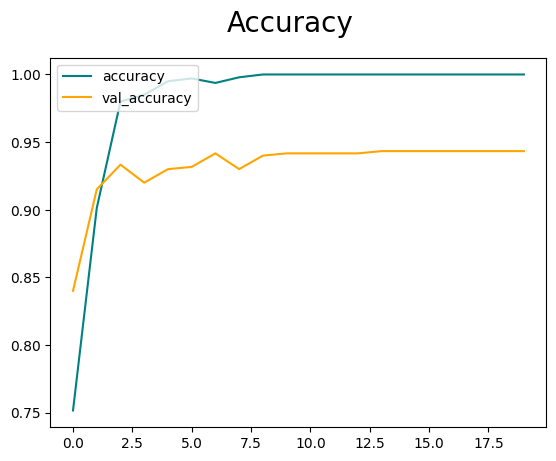

In [49]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [50]:
result=model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [51]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [52]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [53]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


10. Test

In [54]:
import cv2

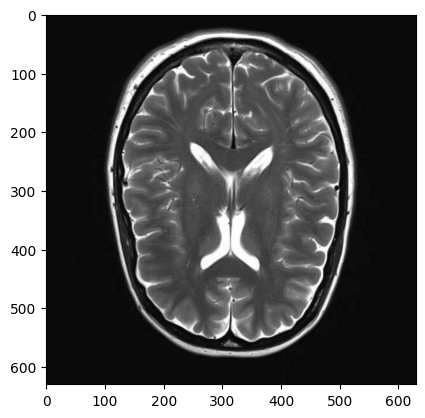

In [55]:
img = cv2.imread('Data/2_classes_Brain_tumor/no/No12.jpg')
plt.imshow(img)
plt.show()

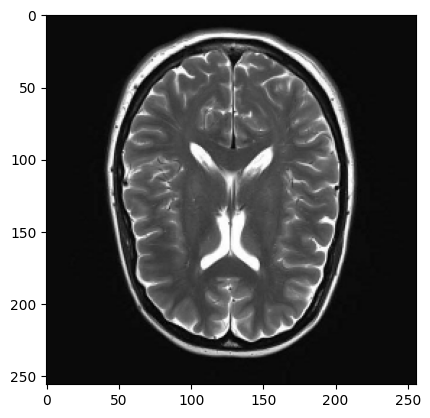

In [56]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [57]:
yhat = model.predict(np.expand_dims(resize/256, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


array([[0.51130223]], dtype=float32)

In [58]:
if yhat > 0.5: 
    print(f'yes tumor')
else:
    print(f'no tumor')

yes tumor


11. Save the Model

In [59]:
from tensorflow.keras.models import load_model

In [60]:
model.save(os.path.join('models','imageclassifier.h5'))

In [62]:
new_model = load_model('models/imageclassifier.h5')

In [63]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


array([[0.51120245]], dtype=float32)